In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
UsageError: unrecognized arguments: autoreload


In [2]:
import copy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from xgboost import XGBRegressor

from batcar import BatCar
from batcar.model_updater.model_updater import ModelUpdater
from batcar.model_updater.data_selectors import RecentSelector
from batcar.model_updater.data_splitters import RecentSplitter
from batcar.model_updater.wrappers import FrameIO, Transformer, Pipeline
from batcar.update_trigger import MonthlyTrigger

In [3]:
plt.style.use('makina-notebook')

Text(0.5, 1.0, 'Synthetic Data')

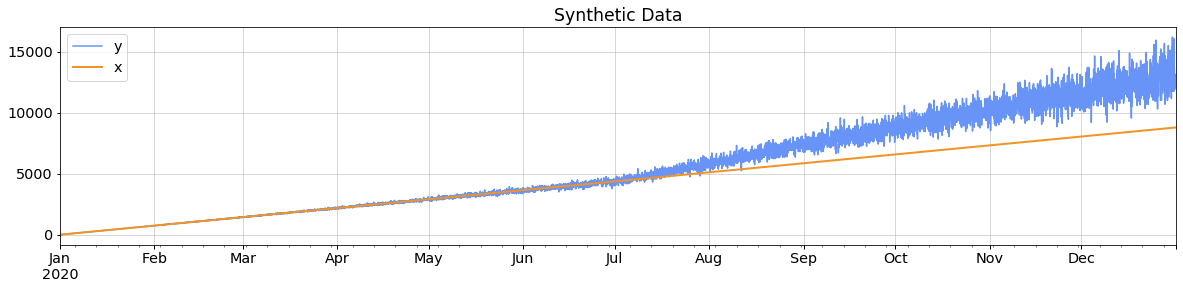

In [4]:
data_times = pd.date_range('2020-01-01 00:00:00', '2021-01-01 00:00:00', freq='1h', closed='left')

n_samples = len(data_times)
n_phase1 = int(n_samples / 2)
n_phase2 = n_samples - n_phase1

x1 = pd.DataFrame(np.arange(n_samples).reshape(-1, 1), index=data_times, columns=['x'])
x2 = pd.DataFrame(np.random.randn(n_samples, 5) * 200, index=data_times, columns=[f'noise {i}' for i in range(5)])

x = pd.concat([x1, x2], axis=1)

y1_clean = np.arange(n_phase1)
y2_clean = np.arange(n_phase2) * 2 + y1_clean[-1]

y_clean = pd.DataFrame(np.concatenate([y1_clean, y2_clean]), index=data_times, columns=['y'])
y_noise = np.random.randn(*y_clean.shape) * (y_clean * 0.03) * (x1.to_numpy()*0.0003)

y = y_clean + y_noise

ax = y.plot.line(figsize=(20,4))
ax = x1.plot.line(lw=2, ax=ax)
ax.set_title('Synthetic Data')

Text(0.5, 1.0, 'x')

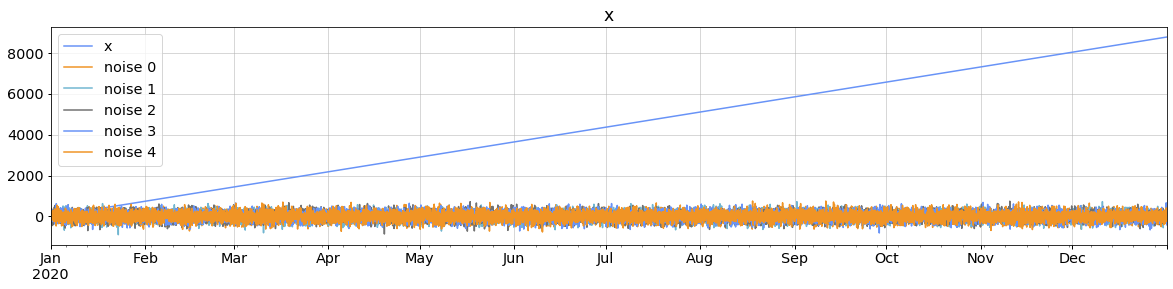

In [5]:
ax = x.plot.line(figsize=(20,4))
ax.set_title('x')

# Run BatCar

## Incorporating Preprocessing and Postprocessing Pipelines
- Let's assume that we have hypotheses as follows:
    1. Only the first colums is relevant to `y`.
    1. `y` is always nonnegative.
    1. Standardization is helpful.
    1. The polynomial feature with degree 2 is helpful.
- The example below shows how these hypotheses is incorporated in BatCar.

In [6]:
def exclude_irrelevant(x: pd.DataFrame):
    return x.iloc[:, [0]]

In [7]:
from sklearn.preprocessing import StandardScaler

preproc = Pipeline([
    exclude_irrelevant,        # any regular function is acceptable
    lambda x: x**2,            # lambda is acceptable
    FrameIO(StandardScaler())  # fit_transformable in sklearn is acceptable with `FrameIO` wrapper
])

y_preproc = Pipeline([
    # you can add functions or fit_transformable as in preproc.
])

y_postproc = Pipeline([
    Transformer.from_func(lambda y_pred: y_pred.clip(0))
])

In [8]:
model = FrameIO(Ridge())

update_interval = '31 days'

data_selector = RecentSelector(744)
model_updater = ModelUpdater.from_generator(model, data_selector=data_selector, preproc=preproc, y_postproc=y_postproc)

batcar = BatCar(update_interval, model_updater)
batcar.drive(x, y, batch_size=1000)

100%|██████████| 9/9 [00:08<00:00,  1.04it/s]

|   episode | build_time          |
|----------:|:--------------------|
|         0 | 2020-02-01 00:00:00 |
|         1 | 2020-03-03 00:00:00 |
|         2 | 2020-04-03 00:00:00 |
|         3 | 2020-05-04 00:00:00 |
|         4 | 2020-06-04 00:00:00 |
|         5 | 2020-07-05 00:00:00 |
|         6 | 2020-08-05 00:00:00 |
|         7 | 2020-09-05 00:00:00 |
|         8 | 2020-10-06 00:00:00 |
|         9 | 2020-11-06 00:00:00 |
|        10 | 2020-12-07 00:00:00 |



Text(0.5, 1.0, "{'mae': 374.24110817107857}")

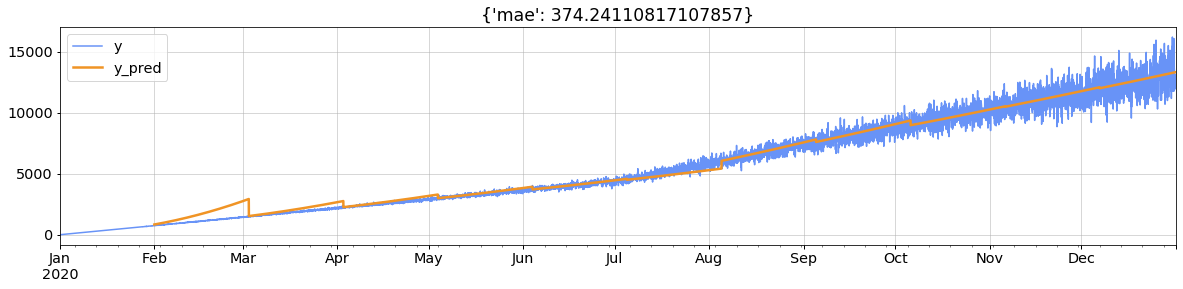

In [9]:
y_pred = batcar.pred_table
y_eval = batcar.eval_table

ax = y.plot.line(figsize=(20,4))
ax = y_pred.iloc[:, 0].rename('y_pred').plot.line(ax=ax, lw=2.5)
ax.legend()
ax.set_title(y_eval.mean().to_dict())

## Using Popular Models with Validation Option

In [10]:
model = FrameIO(XGBRegressor())

update_interval = '31 days'

data_selector = RecentSelector(744)
data_splitter = RecentSplitter(frac=0.2)

model_updater = ModelUpdater.from_generator(model, data_selector=data_selector, data_splitter=data_splitter, preproc=preproc, y_postproc=y_postproc)

batcar = BatCar(update_interval, model_updater)
batcar.drive(x, y, batch_size=1000)

100%|██████████| 9/9 [00:09<00:00,  1.07s/it]

|   episode | build_time          |
|----------:|:--------------------|
|         0 | 2020-02-01 00:00:00 |
|         1 | 2020-03-03 00:00:00 |
|         2 | 2020-04-03 00:00:00 |
|         3 | 2020-05-04 00:00:00 |
|         4 | 2020-06-04 00:00:00 |
|         5 | 2020-07-05 00:00:00 |
|         6 | 2020-08-05 00:00:00 |
|         7 | 2020-09-05 00:00:00 |
|         8 | 2020-10-06 00:00:00 |
|         9 | 2020-11-06 00:00:00 |
|        10 | 2020-12-07 00:00:00 |



Text(0.5, 1.0, "{'mae': 845.2140408821426}")

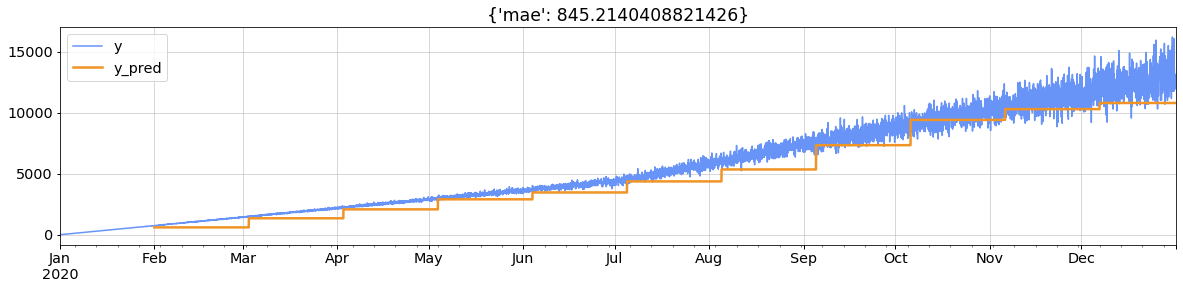

In [11]:
y_pred = batcar.pred_table
y_eval = batcar.eval_table

ax = y.plot.line(figsize=(20,4))
ax = y_pred.iloc[:, 0].rename('y_pred').plot.line(ax=ax, lw=2.5)
ax.legend()
ax.set_title(y_eval.mean().to_dict())